In [1]:
import os
import re
import zipfile

import numpy as np
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import pandas as pd

from PIL import Image
import ast
import json
from glob import glob

In [2]:
path_tiny = '/home/sogangori/Downloads/tiny_set/'
path_tiny_certain_train = path_tiny + 'erase_with_uncertain_dataset/train/'
path_tiny_certain_test = path_tiny + 'erase_with_uncertain_dataset/test/'

In [3]:
#path_tiny_annotation = path_tiny + 'annotations/tiny_set_train.json'
path_tiny_annotation = path_tiny + 'annotations/tiny_set_train_with_dense.json'
path_tiny_annotation

'/home/sogangori/Downloads/tiny_set/annotations/tiny_set_train_with_dense.json'

In [4]:
#os.path.isfile('/home/sogangori/Downloads/tiny_set/annotations/tiny_set_train.json')
os.path.isfile(path_tiny_annotation)

True

In [5]:
with open(path_tiny_annotation, 'r') as j:
    contents = json.loads(j.read())                    

In [6]:
contents

{'type': 'instance',
 'annotations': [{'segmentation': [[1081.124389319407,
     17.45930926910859,
     1267.431666947439,
     17.45930926910859,
     1267.431666947439,
     67.73270164492683,
     1081.124389319407,
     67.73270164492683]],
   'bbox': [1081.124389319407,
    17.45930926910859,
    186.3072776280319,
    50.27339237581825],
   'category_id': 1,
   'area': 9366.298870664552,
   'iscrowd': 0,
   'image_id': 0,
   'id': 0,
   'ignore': True,
   'uncertain': False,
   'logo': True,
   'in_dense_image': False},
  {'segmentation': [[517.3621985215059,
     323.7494218755995,
     536.3942919951216,
     323.7494218755995,
     536.3942919951216,
     360.0675452013983,
     517.3621985215059,
     360.0675452013983]],
   'bbox': [517.3621985215059,
    323.7494218755995,
    19.03209347361576,
    36.31812332579875],
   'category_id': 1,
   'area': 691.2099179229067,
   'iscrowd': 0,
   'image_id': 0,
   'id': 1,
   'ignore': False,
   'uncertain': False,
   'logo': Fals

In [7]:
len(contents), contents.keys()

(4, dict_keys(['type', 'annotations', 'images', 'categories']))

In [8]:
images = contents['images']
annotations = contents['annotations']
print(len(images), type(images), images[:2])
print(len(annotations), type(annotations), annotations[0])

794 <class 'list'> [{'file_name': 'labeled_images/bb_V0032_I0001640.jpg', 'height': 720, 'width': 1280, 'id': 0}, {'file_name': 'labeled_images/bb_V0014_I0002600.jpg', 'height': 1080, 'width': 1920, 'id': 1}]
42197 <class 'list'> {'segmentation': [[1081.124389319407, 17.45930926910859, 1267.431666947439, 17.45930926910859, 1267.431666947439, 67.73270164492683, 1081.124389319407, 67.73270164492683]], 'bbox': [1081.124389319407, 17.45930926910859, 186.3072776280319, 50.27339237581825], 'category_id': 1, 'area': 9366.298870664552, 'iscrowd': 0, 'image_id': 0, 'id': 0, 'ignore': True, 'uncertain': False, 'logo': True, 'in_dense_image': False}


In [9]:
file_name_id_dict = dict()
for image in images:
    file_name = image['file_name']
    id_num = image['id']
    target = 'dense'
    #target = 'labeled'
    if target in file_name:
        file_name_id_dict[file_name] = id_num

In [10]:
id_values = file_name_id_dict.values()
len(id_values), len(set(id_values)), min(id_values), max(id_values)

(48, 48, 717, 764)

In [84]:
id_bbox_dict = dict()
for annotation in annotations:    
    image_id = annotation['image_id']
    bbox = annotation['bbox']
    ignore = annotation['ignore']
    uncertain = annotation['uncertain']
        
    bbox = np.array(bbox, dtype=np.int)
    x, y, w, h = bbox
    
    if True:
        margin = 10
        x -= margin
        y -= margin
        h += margin * 2
        w += margin * 2
    bbox = [y, x, y+h, x+w]
    #print('bbox', bbox)
    #break
    
    if ignore:
        #print(image_id, bbox, ignore, uncertain)
        pass
    else:
        if image_id in id_bbox_dict.keys():
            id_bbox_dict[image_id].extend(bbox)
        else:
            id_bbox_dict[image_id] = bbox

In [85]:
np.array(id_bbox_dict[1]).reshape([-1, 4]).shape

(82, 4)

In [86]:
path_tiny_certain_train, path_tiny_certain_test

('/home/sogangori/Downloads/tiny_set/erase_with_uncertain_dataset/train/',
 '/home/sogangori/Downloads/tiny_set/erase_with_uncertain_dataset/test/')

In [87]:
input_list_train = []
bbox_list_train = []
for file_name in file_name_id_dict.keys():
    file_full_path_train = path_tiny_certain_train + file_name
    file_full_path_test = path_tiny_certain_test + file_name
    
    file_id = file_name_id_dict[file_name]
    bboxes = id_bbox_dict[file_id]
    bboxes_2d = np.reshape(bboxes, [-1, 4])
        
    if os.path.isfile(file_full_path_train):
        img = Image.open(file_full_path_train)
        img_arr = np.array(img)
                
        h, w, c = img_arr.shape
        scale = np.array((h, w, h, w))
        scale = np.reshape(scale, (1, 4))
        bbox_norm = bboxes_2d.astype(np.float) / scale.astype(np.float)
        cls = np.ones_like(bbox_norm[:, :1])
        cls_bbox_norm = np.concatenate((cls, bbox_norm), axis=1)
        
        input_list_train.append(img_arr)
        bbox_list_train.append(cls_bbox_norm)        
        if len(input_list_train)%100==0:
            print('reading image', len(file_name_id_dict.keys()), len(input_list_train))
        elif os.path.isfile(file_full_path_test):        
            continue
        break
print('input_list_train', len(input_list_train))

input_list_train 1


In [88]:
def visualize_detections_simple(
    image, boxes, classes, figsize=(12, 12), linewidth=1, color=[0, 0, 1]
):
    """Visualize Detections"""
    image = np.array(image, dtype=np.uint8)
    img_h, img_w, img_c = image.shape
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    boxes_width = boxes[:, 3] - boxes[:, 1]
    boxes_height = boxes[:, 2] - boxes[:, 0]
    box_min_width = np.min(boxes_width)
    box_max_width = np.max(boxes_width)
    title = str.format('(%dx%d) %d box, width:%d ~ %d' 
                       %(img_h, img_w, len(boxes), box_min_width, box_max_width))
    plt.title(title)
    for box, cls in zip(boxes, classes):
        y1, x1, y2, x2 = box        
        w, h = x2 - x1, y2 - y1
        patch = plt.Rectangle(
            [x1, y1], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        
    plt.show()
    return ax

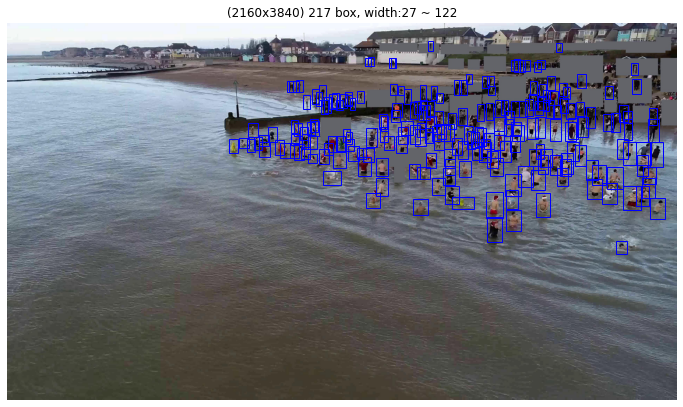

In [89]:
i = 0
img_arr = input_list_train[i]
sample_box = bbox_list_train[i]
label = np.ones_like(sample_box[:, 0])
bbox = sample_box[:, 1:]

h, w, c = img_arr.shape
scale = np.array((h, w, h, w))
scale = np.reshape(scale, (1, 4))
bbox_norm = bbox.astype(np.float) * scale.astype(np.float)
#print('bbox_norm', bbox, bbox_norm)
ax = visualize_detections_simple(img_arr,bbox_norm,label)

In [90]:
WATER_CLASSES = ['bg', 'human']
num_classes = len(WATER_CLASSES)

In [91]:
import os
import re
import zipfile

import numpy as np
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow_datasets as tfds


def swap_xy(boxes):
    """Swaps order the of x and y coordinates of the boxes.
    Arguments:
      boxes: A tensor with shape `(num_boxes, 4)` representing bounding boxes.
    Returns:
      swapped boxes with shape same as that of boxes.
    """
    return tf.stack([boxes[:, 1], boxes[:, 0], boxes[:, 3], boxes[:, 2]], axis=-1)


def convert_to_xywh(boxes):
    """Changes the box format to center, width and height.
    Arguments:
      boxes: A tensor of rank 2 or higher with a shape of `(..., num_boxes, 4)`
        representing bounding boxes where each box is of the format
        `[xmin, ymin, xmax, ymax]`.
    Returns:
      converted boxes with shape same as that of boxes.
    """
    return tf.concat(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]],
        axis=-1,
    )


def convert_to_corners(boxes):
    """Changes the box format to corner coordinates
    Arguments:
      boxes: A tensor of rank 2 or higher with a shape of `(..., num_boxes, 4)`
        representing bounding boxes where each box is of the format
        `[x, y, width, height]`.
    Returns:
      converted boxes with shape same as that of boxes.
    """
    return tf.concat(
        [boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0],
        axis=-1,
    )


"""
## Computing pairwise Intersection Over Union (IOU)
As we will see later in the example, we would be assigning ground truth boxes
to anchor boxes based on the extent of overlapping. This will require us to
calculate the Intersection Over Union (IOU) between all the anchor
boxes and ground truth boxes pairs.
"""


def compute_iou(boxes1, boxes2):
    """Computes pairwise IOU matrix for given two sets of boxes
    Arguments:
      boxes1: A tensor with shape `(N, 4)` representing bounding boxes
        where each box is of the format `[x, y, width, height]`.
        boxes2: A tensor with shape `(M, 4)` representing bounding boxes
        where each box is of the format `[x, y, width, height]`.
    Returns:
      pairwise IOU matrix with shape `(N, M)`, where the value at ith row
        jth column holds the IOU between ith box and jth box from
        boxes1 and boxes2 respectively.
    """
    boxes1_corners = convert_to_corners(boxes1)
    boxes2_corners = convert_to_corners(boxes2)
    lu = tf.maximum(boxes1_corners[:, None, :2], boxes2_corners[:, :2])
    rd = tf.minimum(boxes1_corners[:, None, 2:], boxes2_corners[:, 2:])
    intersection = tf.maximum(0.0, rd - lu)
    intersection_area = intersection[:, :, 0] * intersection[:, :, 1]
    boxes1_area = boxes1[:, 2] * boxes1[:, 3]
    boxes2_area = boxes2[:, 2] * boxes2[:, 3]
    union_area = tf.maximum(
        boxes1_area[:, None] + boxes2_area - intersection_area, 1e-8
    )
    return tf.clip_by_value(intersection_area / union_area, 0.0, 1.0)


def visualize_detections(
    image, boxes, classes, scores, figsize=(7, 7), linewidth=1, color=[0, 0, 1]
):
    """Visualize Detections"""
    image = np.array(image, dtype=np.uint8)
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    for box, _cls, score in zip(boxes, classes, scores):
        text = "{}: {:.2f}".format(_cls, score)
        x1, y1, x2, y2 = box
        w, h = x2 - x1, y2 - y1
        patch = plt.Rectangle(
            [x1, y1], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        
    plt.show()
    return ax


"""
## Implementing Anchor generator
Anchor boxes are fixed sized boxes that the model uses to predict the bounding
box for an object. It does this by regressing the offset between the location
of the object's center and the center of an anchor box, and then uses the width
and height of the anchor box to predict a relative scale of the object. In the
case of RetinaNet, each location on a given feature map has nine anchor boxes
(at three scales and three ratios).
"""


class AnchorBox:
    """Generates anchor boxes.
    This class has operations to generate anchor boxes for feature maps at
    strides `[8, 16, 32, 64, 128]`. Where each anchor each box is of the
    format `[x, y, width, height]`.
    Attributes:
      aspect_ratios: A list of float values representing the aspect ratios of
        the anchor boxes at each location on the feature map
      scales: A list of float values representing the scale of the anchor boxes
        at each location on the feature map.
      num_anchors: The number of anchor boxes at each location on feature map
      areas: A list of float values representing the areas of the anchor
        boxes for each feature map in the feature pyramid.
      strides: A list of float value representing the strides for each feature
        map in the feature pyramid.
    """

    def __init__(self):
        self.aspect_ratios = [0.5, 1.0, 2.0]
        self.scales = [2 ** x for x in [0, 1 / 3, 2 / 3]]

        self._num_anchors = len(self.aspect_ratios) * len(self.scales)
        self._strides = [2 ** i for i in range(3, 8)]
        self._areas = [x ** 2 for x in [32.0, 64.0, 128.0, 256.0, 512.0]]
        self._anchor_dims = self._compute_dims()

    def _compute_dims(self):
        """Computes anchor box dimensions for all ratios and scales at all levels
        of the feature pyramid.
        """
        anchor_dims_all = []
        for area in self._areas:
            anchor_dims = []
            for ratio in self.aspect_ratios:
                anchor_height = tf.math.sqrt(area / ratio)
                anchor_width = area / anchor_height
                dims = tf.reshape(
                    tf.stack([anchor_width, anchor_height], axis=-1), [1, 1, 2]
                )
                for scale in self.scales:
                    anchor_dims.append(scale * dims)
            anchor_dims_all.append(tf.stack(anchor_dims, axis=-2))
        return anchor_dims_all

    def _get_anchors(self, feature_height, feature_width, level):
        """Generates anchor boxes for a given feature map size and level
        Arguments:
          feature_height: An integer representing the height of the feature map.
          feature_width: An integer representing the width of the feature map.
          level: An integer representing the level of the feature map in the
            feature pyramid.
        Returns:
          anchor boxes with the shape
          `(feature_height * feature_width * num_anchors, 4)`
        """
        rx = tf.range(feature_width, dtype=tf.float32) + 0.5
        ry = tf.range(feature_height, dtype=tf.float32) + 0.5
        centers = tf.stack(tf.meshgrid(rx, ry), axis=-1) * self._strides[level - 3]
        centers = tf.expand_dims(centers, axis=-2)
        centers = tf.tile(centers, [1, 1, self._num_anchors, 1])
        dims = tf.tile(
            self._anchor_dims[level - 3], [feature_height, feature_width, 1, 1]
        )
        anchors = tf.concat([centers, dims], axis=-1)
        return tf.reshape(
            anchors, [feature_height * feature_width * self._num_anchors, 4]
        )

    def get_anchors(self, image_height, image_width):
        """Generates anchor boxes for all the feature maps of the feature pyramid.
        Arguments:
          image_height: Height of the input image.
          image_width: Width of the input image.
        Returns:
          anchor boxes for all the feature maps, stacked as a single tensor
            with shape `(total_anchors, 4)`
        """
        anchors = [
            self._get_anchors(
                tf.math.ceil(image_height / 2 ** i),
                tf.math.ceil(image_width / 2 ** i),
                i,
            )
            for i in range(3, 8)
        ]
        return tf.concat(anchors, axis=0)


"""
## Preprocessing data
Preprocessing the images involves two steps:
- Resizing the image: Images are resized such that the shortest size is equal
to 800 px, after resizing if the longest side of the image exceeds 1333 px,
the image is resized such that the longest size is now capped at 1333 px.
- Applying augmentation: Random scale jittering  and random horizontal flipping
are the only augmentations applied to the images.
Along with the images, bounding boxes are rescaled and flipped if required.
"""


def random_flip_horizontal(image, boxes):
    """Flips image and boxes horizontally with 50% chance
    Arguments:
      image: A 3-D tensor of shape `(height, width, channels)` representing an
        image.
      boxes: A tensor with shape `(num_boxes, 4)` representing bounding boxes,
        having normalized coordinates.
    Returns:
      Randomly flipped image and boxes
    """
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        boxes = tf.stack(
            [1 - boxes[:, 2], boxes[:, 1], 1 - boxes[:, 0], boxes[:, 3]], axis=-1
        )
    return image, boxes


def resize_and_pad_image(
    image, min_side=1024.0, max_side=11333.0, jitter=[128*7, 128*9], stride=128.0
):
    #image, min_side=800.0, max_side=1333.0, jitter=[640, 1024], stride=128.0
    """Resizes and pads image while preserving aspect ratio.
    1. Resizes images so that the shorter side is equal to `min_side`
    2. If the longer side is greater than `max_side`, then resize the image
      with longer side equal to `max_side`
    3. Pad with zeros on right and bottom to make the image shape divisible by
    `stride`
    Arguments:
      image: A 3-D tensor of shape `(height, width, channels)` representing an
        image.
      min_side: The shorter side of the image is resized to this value, if
        `jitter` is set to None.
      max_side: If the longer side of the image exceeds this value after
        resizing, the image is resized such that the longer side now equals to
        this value.
      jitter: A list of floats containing minimum and maximum size for scale
        jittering. If available, the shorter side of the image will be
        resized to a random value in this range.
      stride: The stride of the smallest feature map in the feature pyramid.
        Can be calculated using `image_size / feature_map_size`.
    Returns:
      image: Resized and padded image.
      image_shape: Shape of the image before padding.
      ratio: The scaling factor used to resize the image
    """
    image_shape = tf.cast(tf.shape(image)[:2], dtype=tf.float32)
    if jitter is not None:
        min_side = tf.random.uniform((), jitter[0], jitter[1], dtype=tf.float32)
    ratio = min_side / tf.reduce_min(image_shape)
    if ratio * tf.reduce_max(image_shape) > max_side:
        ratio = max_side / tf.reduce_max(image_shape)
    image_shape = ratio * image_shape
    image = tf.image.resize(image, tf.cast(image_shape, dtype=tf.int32))
    padded_image_shape = tf.cast(
        tf.math.ceil(image_shape / stride) * stride, dtype=tf.int32
    )
    image = tf.image.pad_to_bounding_box(
        image, 0, 0, padded_image_shape[0], padded_image_shape[1]
    )
    return image, image_shape, ratio


def preprocess_data(image, cls_bbox):
    """Applies preprocessing step to a single sample
    Arguments:
      sample: A dict representing a single training sample.
    Returns:
      image: Resized and padded image with random horizontal flipping applied.
      bbox: Bounding boxes with the shape `(num_objects, 4)` where each box is
        of the format `[x, y, width, height]`.
      class_id: An tensor representing the class id of the objects, having
        shape `(num_objects,)`.
    """
    #image = sample["image"]
    #bbox = swap_xy(sample["objects"]["bbox"])
    #class_id = tf.cast(sample["objects"]["label"], dtype=tf.int32)
    #image = sample[0]
    #cls_bbox = sample[1]
    
    bbox = swap_xy(cls_bbox[:, 1:])
    class_id = tf.cast(cls_bbox[:, 0], dtype=tf.int32)    

    image, bbox = random_flip_horizontal(image, bbox)
    image, image_shape, _ = resize_and_pad_image(image)

    bbox = tf.stack(
        [
            bbox[:, 0] * image_shape[1],
            bbox[:, 1] * image_shape[0],
            bbox[:, 2] * image_shape[1],
            bbox[:, 3] * image_shape[0],
        ],
        axis=-1,
    )
    bbox = convert_to_xywh(bbox)
    return image, bbox, class_id


"""
## Encoding labels
The raw labels, consisting of bounding boxes and class ids need to be
transformed into targets for training. This transformation consists of
the following steps:
- Generating anchor boxes for the given image dimensions
- Assigning ground truth boxes to the anchor boxes
- The anchor boxes that are not assigned any objects, are either assigned the
background class or ignored depending on the IOU
- Generating the classification and regression targets using anchor boxes
"""


class LabelEncoder:
    """Transforms the raw labels into targets for training.
    This class has operations to generate targets for a batch of samples which
    is made up of the input images, bounding boxes for the objects present and
    their class ids.
    Attributes:
      anchor_box: Anchor box generator to encode the bounding boxes.
      box_variance: The scaling factors used to scale the bounding box targets.
    """

    def __init__(self):
        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            [0.1, 0.1, 0.2, 0.2], dtype=tf.float32
        )

    def _match_anchor_boxes(
        self, anchor_boxes, gt_boxes, match_iou=0.5, ignore_iou=0.4
    ):
        """Matches ground truth boxes to anchor boxes based on IOU.
        1. Calculates the pairwise IOU for the M `anchor_boxes` and N `gt_boxes`
          to get a `(M, N)` shaped matrix.
        2. The ground truth box with the maximum IOU in each row is assigned to
          the anchor box provided the IOU is greater than `match_iou`.
        3. If the maximum IOU in a row is less than `ignore_iou`, the anchor
          box is assigned with the background class.
        4. The remaining anchor boxes that do not have any class assigned are
          ignored during training.
        Arguments:
          anchor_boxes: A float tensor with the shape `(total_anchors, 4)`
            representing all the anchor boxes for a given input image shape,
            where each anchor box is of the format `[x, y, width, height]`.
          gt_boxes: A float tensor with shape `(num_objects, 4)` representing
            the ground truth boxes, where each box is of the format
            `[x, y, width, height]`.
          match_iou: A float value representing the minimum IOU threshold for
            determining if a ground truth box can be assigned to an anchor box.
          ignore_iou: A float value representing the IOU threshold under which
            an anchor box is assigned to the background class.
        Returns:
          matched_gt_idx: Index of the matched object
          positive_mask: A mask for anchor boxes that have been assigned ground
            truth boxes.
          ignore_mask: A mask for anchor boxes that need to by ignored during
            training
        """
        iou_matrix = compute_iou(anchor_boxes, gt_boxes)
        max_iou = tf.reduce_max(iou_matrix, axis=1)
        matched_gt_idx = tf.argmax(iou_matrix, axis=1)
        positive_mask = tf.greater_equal(max_iou, match_iou)
        negative_mask = tf.less(max_iou, ignore_iou)
        ignore_mask = tf.logical_not(tf.logical_or(positive_mask, negative_mask))
        return (
            matched_gt_idx,
            tf.cast(positive_mask, dtype=tf.float32),
            tf.cast(ignore_mask, dtype=tf.float32),
        )

    def _compute_box_target(self, anchor_boxes, matched_gt_boxes):
        """Transforms the ground truth boxes into targets for training"""
        box_target = tf.concat(
            [
                (matched_gt_boxes[:, :2] - anchor_boxes[:, :2]) / anchor_boxes[:, 2:],
                tf.math.log(matched_gt_boxes[:, 2:] / anchor_boxes[:, 2:]),
            ],
            axis=-1,
        )
        box_target = box_target / self._box_variance
        return box_target

    def _encode_sample(self, image_shape, gt_boxes, cls_ids):
        """Creates box and classification targets for a single sample"""
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        cls_ids = tf.cast(cls_ids, dtype=tf.float32)
        matched_gt_idx, positive_mask, ignore_mask = self._match_anchor_boxes(
            anchor_boxes, gt_boxes
        )
        matched_gt_boxes = tf.gather(gt_boxes, matched_gt_idx)
        box_target = self._compute_box_target(anchor_boxes, matched_gt_boxes)
        matched_gt_cls_ids = tf.gather(cls_ids, matched_gt_idx)
        cls_target = tf.where(
            tf.not_equal(positive_mask, 1.0), -1.0, matched_gt_cls_ids
        )
        cls_target = tf.where(tf.equal(ignore_mask, 1.0), -2.0, cls_target)
        cls_target = tf.expand_dims(cls_target, axis=-1)
        label = tf.concat([box_target, cls_target], axis=-1)
        return label

    def encode_batch(self, batch_images, gt_boxes, cls_ids):
        """Creates box and classification targets for a batch"""
        images_shape = tf.shape(batch_images)
        batch_size = images_shape[0]

        labels = tf.TensorArray(dtype=tf.float32, size=batch_size, dynamic_size=True)
        for i in range(batch_size):
            label = self._encode_sample(images_shape, gt_boxes[i], cls_ids[i])
            labels = labels.write(i, label)
        #batch_images = tf.keras.applications.resnet.preprocess_input(batch_images)
        batch_images = tf.cast(batch_images, tf.float32)# / 255.0
        return batch_images, labels.stack()

In [92]:
#https://towardsdatascience.com/building-a-resnet-in-keras-e8f1322a49ba
from tensorflow import Tensor
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization,\
                                    Add, AveragePooling2D, Flatten, Dense, MaxPool2D
from tensorflow.keras.models import Model

def relu_bn(inputs: Tensor) -> Tensor:
    relu = ReLU()(inputs)
    bn = BatchNormalization()(relu)
    return bn

def relu(inputs: Tensor) -> Tensor:
    relu = ReLU()(inputs)    
    return relu

def residual_block(x: Tensor, downsample: bool, filters: int, kernel_size: int = 3) -> Tensor:
    y = Conv2D(kernel_size=kernel_size,
               strides= (1 if not downsample else 2),
               filters=filters, 
               activation='relu',
               padding="same")(x)    
    y = Conv2D(kernel_size=kernel_size,
               strides=1,
               filters=filters,
               padding="same")(y)

    if downsample:
        x = Conv2D(kernel_size=1,
                   strides=2,
                   filters=filters,
                   padding="same")(x)
    out = Add()([x, y])
    out = relu(out)
    return out

def create_resnet_backbone():
    
    inputs = Input(shape=(None, None, 3))
    num_filters = 64
    
    #t = BatchNormalization()(inputs)    
    t = Conv2D(kernel_size=3,
               strides=2,
               filters=num_filters,
               activation='relu',
               padding="same")(inputs)
    t = MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same')(t)
    
    num_blocks_list = [2, 5, 5, 2]
    t_list = []
    for i in range(len(num_blocks_list)):
        num_blocks = num_blocks_list[i]
        for j in range(num_blocks):
            t = residual_block(t, downsample=(j==0 and i!=0), filters=num_filters)
        if i>=1:
            t_list.append(t)
        num_filters *= 2
    
    #t = AveragePooling2D(4)(t)
    #t = Flatten()(t)
    #outputs = Dense(10, activation='softmax')(t)
    #8, 16, 32, 64, 128
    model = Model(inputs, t_list)
    
    return model

In [93]:
"""
## Building the ResNet50 backbone
RetinaNet uses a ResNet based backbone, using which a feature pyramid network
is constructed. In the example we use ResNet50 as the backbone, and return the
feature maps at strides 8, 16 and 32.
"""

"""
## Building Feature Pyramid Network as a custom layer
"""

class FeaturePyramid(keras.layers.Layer):
    """Builds the Feature Pyramid with the feature maps from the backbone.
    Attributes:
      num_classes: Number of classes in the dataset.
      backbone: The backbone to build the feature pyramid from.
        Currently supports ResNet50 only.
    """

    def __init__(self, backbone=None, **kwargs):
        super(FeaturePyramid, self).__init__(name="FeaturePyramid", **kwargs)
        self.backbone = backbone if backbone else create_resnet_backbone()
        self.conv_c3_1x1 = keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c4_1x1 = keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c5_1x1 = keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c3_3x3 = keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c4_3x3 = keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c5_3x3 = keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c6_3x3 = keras.layers.Conv2D(256, 3, 2, "same")
        self.conv_c7_3x3 = keras.layers.Conv2D(256, 3, 2, "same")
        self.upsample_2x = keras.layers.UpSampling2D(2)
        self.dropout = keras.layers.Dropout(.1)#20.8.8

    def call(self, images, training=False):
        c3_output, c4_output, c5_output = self.backbone(images, training=training)
        c3_output = self.dropout(c3_output)#20.8.8
        c4_output = self.dropout(c4_output)#20.8.8
        c5_output = self.dropout(c5_output)#20.8.8
        p3_output = self.conv_c3_1x1(c3_output)#err
        p4_output = self.conv_c4_1x1(c4_output)
        p5_output = self.conv_c5_1x1(c5_output)
        p4_output = p4_output + self.upsample_2x(p5_output)
        p3_output = p3_output + self.upsample_2x(p4_output)
        p3_output = self.conv_c3_3x3(p3_output)
        p4_output = self.conv_c4_3x3(p4_output)
        p5_output = self.conv_c5_3x3(p5_output)
        p6_output = self.conv_c6_3x3(c5_output)
        p7_output = self.conv_c7_3x3(tf.nn.relu(p6_output))
        #8, 16, 32, 64, 128
        return p3_output, p4_output, p5_output, p6_output, p7_output


"""
## Building the classification and box regression heads.
The RetinaNet model has separate heads for bounding box regression and
for predicting class probabilities for the objects. These heads are shared
between all the feature maps of the feature pyramid.
"""


def build_head(output_filters, bias_init):
    """Builds the class/box predictions head.
    Arguments:
      output_filters: Number of convolution filters in the final layer.
      bias_init: Bias Initializer for the final convolution layer.
    Returns:
      A keras sequential model representing either the classification
        or the box regression head depending on `output_filters`.
    """
    head = keras.Sequential([keras.Input(shape=[None, None, 256])])
    kernel_init = tf.initializers.RandomNormal(0.0, 0.01)
    for _ in range(4):
        head.add(
            keras.layers.Conv2D(256, 3, padding="same", kernel_initializer=kernel_init)
        )
        head.add(keras.layers.ReLU())
    head.add(
        keras.layers.Conv2D(output_filters, 3, 1, padding="same", kernel_initializer=kernel_init, bias_initializer=bias_init, )
    )
    return head


"""
## Building RetinaNet using a subclassed model
"""

def get_backbone():
    """Builds ResNet50 with pre-trained imagenet weights"""
    backbone = keras.applications.ResNet50(
        include_top=False, input_shape=[None, None, 3]
    )
    c3_output, c4_output, c5_output = [
        backbone.get_layer(layer_name).output
        for layer_name in ["conv3_block4_out", "conv4_block6_out", "conv5_block3_out"]
    ]
    return keras.Model(
        inputs=[backbone.inputs], outputs=[c3_output, c4_output, c5_output]
    )

class RetinaNet(keras.Model):
    """A subclassed Keras model implementing the RetinaNet architecture.
    Attributes:
      num_classes: Number of classes in the dataset.
      backbone: The backbone to build the feature pyramid from.
        Currently supports ResNet50 only.
    """

    def __init__(self, num_classes, backbone=None, **kwargs):
        super(RetinaNet, self).__init__(name="RetinaNet", **kwargs)
        #backbone = get_backbone()        
        backbone = create_resnet_backbone()
        self.fpn = FeaturePyramid(backbone)
        self.num_classes = num_classes

        prior_probability = tf.constant_initializer(-np.log((1 - 0.01) / 0.01))
        self.cls_head = build_head(9 * num_classes, prior_probability)
        self.box_head = build_head(9 * 4, "zeros")

    def call(self, image, training=False):
        features = self.fpn(image, training=training)
        N = tf.shape(image)[0]
        cls_outputs = []
        box_outputs = []
        for feature in features:            
            box_outputs.append(tf.reshape(self.box_head(feature), [N, -1, 4]))
            cls_outputs.append(
                tf.reshape(self.cls_head(feature), [N, -1, self.num_classes])
            )
        cls_outputs = tf.concat(cls_outputs, axis=1)
        box_outputs = tf.concat(box_outputs, axis=1)
        return tf.concat([box_outputs, cls_outputs], axis=-1)


"""
## Implementing a custom layer to decode predictions
"""


class DecodePredictions(tf.keras.layers.Layer):
    """A Keras layer that decodes predictions of the RetinaNet model.
    Attributes:
      num_classes: Number of classes in the dataset
      confidence_threshold: Minimum class probability, below which detections
        are pruned.
      nms_iou_threshold: IOU threshold for the NMS operation
      max_detections_per_class: Maximum number of detections to retain per
       class.
      max_detections: Maximum number of detections to retain across all
        classes.
      box_variance: The scaling factors used to scale the bounding box
        predictions.
    """

    def __init__(
        self,
        num_classes=num_classes,
        confidence_threshold=0.05,
        nms_iou_threshold=0.5,
        max_detections_per_class=100,
        max_detections=100,
        box_variance=[0.1, 0.1, 0.2, 0.2],
        **kwargs
    ):
        super(DecodePredictions, self).__init__(**kwargs)
        self.num_classes = num_classes
        self.confidence_threshold = confidence_threshold
        self.nms_iou_threshold = nms_iou_threshold
        self.max_detections_per_class = max_detections_per_class
        self.max_detections = max_detections

        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            [0.1, 0.1, 0.2, 0.2], dtype=tf.float32
        )

    def _decode_box_predictions(self, anchor_boxes, box_predictions):
        boxes = box_predictions * self._box_variance
        boxes = tf.concat(
            [
                boxes[:, :, :2] * anchor_boxes[:, :, 2:] + anchor_boxes[:, :, :2],
                tf.math.exp(boxes[:, :, 2:]) * anchor_boxes[:, :, 2:],
            ],
            axis=-1,
        )
        boxes_transformed = convert_to_corners(boxes)
        return boxes_transformed

    def call(self, images, predictions):
        image_shape = tf.cast(tf.shape(images), dtype=tf.float32)
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        box_predictions = predictions[:, :, :4]
        cls_predictions = tf.nn.sigmoid(predictions[:, :, 4:])
        boxes = self._decode_box_predictions(anchor_boxes[None, ...], box_predictions)

        return tf.image.combined_non_max_suppression(
            tf.expand_dims(boxes, axis=2),
            cls_predictions,
            self.max_detections_per_class,
            self.max_detections,
            self.nms_iou_threshold,
            self.confidence_threshold,
            clip_boxes=False,
        )


"""
## Implementing Smooth L1 loss and Focal Loss as keras custom losses
"""


class RetinaNetBoxLoss(tf.losses.Loss):
    """Implements Smooth L1 loss"""

    def __init__(self, delta):
        super(RetinaNetBoxLoss, self).__init__(
            reduction="none", name="RetinaNetBoxLoss"
        )
        self._delta = delta

    def call(self, y_true, y_pred):
        difference = y_true - y_pred
        absolute_difference = tf.abs(difference)
        squared_difference = difference ** 2
        loss = tf.where(
            tf.less(absolute_difference, self._delta),
            0.5 * squared_difference,
            absolute_difference - 0.5,
        )
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetClassificationLoss(tf.losses.Loss):
    """Implements Focal loss"""

    def __init__(self, alpha, gamma):
        super(RetinaNetClassificationLoss, self).__init__(
            reduction="none", name="RetinaNetClassificationLoss"
        )
        self._alpha = alpha
        self._gamma = gamma

    def call(self, y_true, y_pred):
        cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=y_true, logits=y_pred
        )
        probs = tf.nn.sigmoid(y_pred)
        alpha = tf.where(tf.equal(y_true, 1.0), self._alpha, (1.0 - self._alpha))
        pt = tf.where(tf.equal(y_true, 1.0), probs, 1 - probs)
        loss = alpha * tf.pow(1.0 - pt, self._gamma) * cross_entropy
        loss = tf.reduce_sum(loss, axis=-1)
        return loss
    

class RetinaNetLoss(tf.losses.Loss):
    """Wrapper to combine both the losses"""

    def __init__(self, num_classes=80, alpha=0.25, gamma=2.0, delta=1.0):
        super(RetinaNetLoss, self).__init__(reduction="auto", name="RetinaNetLoss")
        self._clf_loss = RetinaNetClassificationLoss(alpha, gamma)
        self._box_loss = RetinaNetBoxLoss(delta)
        self._num_classes = num_classes

    def call(self, y_true, y_pred):
        # return tf.concat([box_outputs, cls_outputs], axis=-1)
        y_pred = tf.cast(y_pred, dtype=tf.float32)
        box_labels = y_true[:, :, :4]
        box_predictions = y_pred[:, :, :4]
        cls_labels = tf.one_hot(
            tf.cast(y_true[:, :, 4], dtype=tf.int32),
            depth=self._num_classes,
            dtype=tf.float32,
        )
        cls_predictions = y_pred[:, :, 4:]
        positive_mask = tf.cast(tf.greater(y_true[:, :, 4], -1.0), dtype=tf.float32)
        ignore_mask = tf.cast(tf.equal(y_true[:, :, 4], -2.0), dtype=tf.float32)
        clf_loss = self._clf_loss(cls_labels, cls_predictions)
        box_loss = self._box_loss(box_labels, box_predictions)
        clf_loss = tf.where(tf.equal(ignore_mask, 1.0), 0.0, clf_loss)
        box_loss = tf.where(tf.equal(positive_mask, 1.0), box_loss, 0.0)
        normalizer = tf.reduce_sum(positive_mask, axis=-1)
        clf_loss = tf.math.divide_no_nan(tf.reduce_sum(clf_loss, axis=-1), normalizer)
        box_loss = tf.math.divide_no_nan(tf.reduce_sum(box_loss, axis=-1), normalizer)
        loss = clf_loss + box_loss
        return loss
 

In [94]:

def visualize_detections(
    image, boxes, classes, scores, figsize=(14, 10), linewidth=1, color=[0, 0, 1]
):
    """Visualize Detections"""
    image = np.array(image, dtype=np.uint8)
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    for box, _cls, score in zip(boxes, classes, scores):
        text = "{}: {:.2f}".format(_cls, score)
        x1, y1, x2, y2 = box
        w, h = x2 - x1, y2 - y1
        patch = plt.Rectangle(
            [x1, y1], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        ax.text(x1, y1, text, bbox={"facecolor": color, "alpha": 0.4}, clip_box=ax.clipbox, clip_on=True,)
    plt.show()
    return ax

In [95]:
#Metric
def recall(y_true, y_pred):
    
    y_cls_symbol = tf.cast(y_true[:, :, 4], dtype=tf.int32)
    h_cls = y_pred[:, :, 4:]
    y_cls_hot = tf.one_hot(y_cls_symbol, depth=num_classes)
    
    h_cls_symbol = tf.argmax(h_cls, axis=-1, output_type=tf.int32)
    true_positives = tf.logical_and(tf.equal(y_cls_symbol, h_cls_symbol), y_cls_symbol>0)
    true_positives = tf.reduce_sum(tf.cast(true_positives, tf.float32), axis=1)
    possible_positives = tf.reduce_sum(tf.cast(y_cls_symbol > 0, tf.float32), axis=1)    
    rec = tf.reduce_mean(true_positives / (possible_positives + 1e-8))    
    return rec

def precision(y_true, y_pred):
    
    y_cls_symbol = tf.cast(y_true[:, :, 4], dtype=tf.int32)
    h_cls = y_pred[:, :, 4:]
    
    y_cls_hot = tf.one_hot(y_cls_symbol, depth=num_classes)    
    h_cls_symbol = tf.argmax(h_cls, axis=-1, output_type=tf.int32)
    
    true_positives = tf.logical_and(tf.equal(y_cls_symbol, h_cls_symbol), y_cls_symbol>0)
    true_positives = tf.reduce_sum(tf.cast(true_positives, tf.float32), axis=1)
    predicted_positives = tf.reduce_sum(tf.cast(h_cls_symbol > 0, tf.float32), axis=1)    
    prec = tf.reduce_mean(true_positives / (predicted_positives + 1e-8))
    return prec

def load_weight():   
    weights_dir = model_dir#"data"
    latest_checkpoint = tf.train.latest_checkpoint(weights_dir)
    print('latest_checkpoint', latest_checkpoint)
    model.load_weights(latest_checkpoint)

In [96]:
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
model_dir = "retinanet/"
label_encoder = LabelEncoder()

loss_fn = RetinaNetLoss(num_classes)
model = RetinaNet(num_classes)

optimizer = tf.optimizers.SGD(learning_rate=1e-4, momentum=0.9)
model.compile(loss=loss_fn, optimizer=optimizer, metrics=[recall, precision])

callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(model_dir, "weights"),
        monitor="loss",
        save_best_only=False,
        save_weights_only=True,
        verbose=0,
    )
]

In [97]:
def generator():
    for i in range(len(input_list_train)):
        x = input_list_train[i]
        y_box = bbox_list_train[i]
        yield (x, y_box)

dataset = tf.data.Dataset.from_generator(
    generator, 
    output_types=(tf.uint8, tf.float32), 
    output_shapes=(tf.TensorShape([None, None, 3]), tf.TensorShape([None, 5])))
dataset_test = tf.data.Dataset.from_generator(
    generator, 
    output_types=(tf.uint8, tf.float32), 
    output_shapes=(tf.TensorShape([None, None, 3]), tf.TensorShape([None, 5])))
dataset
np.set_printoptions(precision=2)
for example in tfds.as_numpy(dataset):
    image = example[0]
    bbox = example[1]    
    print(image.dtype, image.shape, bbox.shape, bbox[0])
    break

uint8 (2160, 3840, 3) (217, 5) [1.   0.15 0.43 0.18 0.44]


In [98]:
batch_size = 1
autotune = tf.data.experimental.AUTOTUNE
train_dataset = dataset.map(preprocess_data, num_parallel_calls=autotune)
train_dataset = train_dataset.shuffle(8 * batch_size)
train_dataset = train_dataset.padded_batch(
    batch_size=batch_size, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
train_dataset = train_dataset.map(
    label_encoder.encode_batch, num_parallel_calls=autotune
)
train_dataset = train_dataset.apply(tf.data.experimental.ignore_errors())
train_dataset = train_dataset.prefetch(autotune)

val_dataset = dataset_test.map(preprocess_data, num_parallel_calls=autotune)
val_dataset = val_dataset.padded_batch(
    batch_size=1, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)

val_dataset = val_dataset.map(
    label_encoder.encode_batch, num_parallel_calls=autotune
)

cls_bbox [[1.   0.15 0.43 0.18 0.44]
 [1.   0.15 0.43 0.18 0.44]
 [1.   0.15 0.42 0.18 0.43]
 ...
 [1.   0.21 0.75 0.25 0.76]
 [1.   0.19 0.79 0.23 0.8 ]
 [1.   0.1  0.79 0.12 0.8 ]]


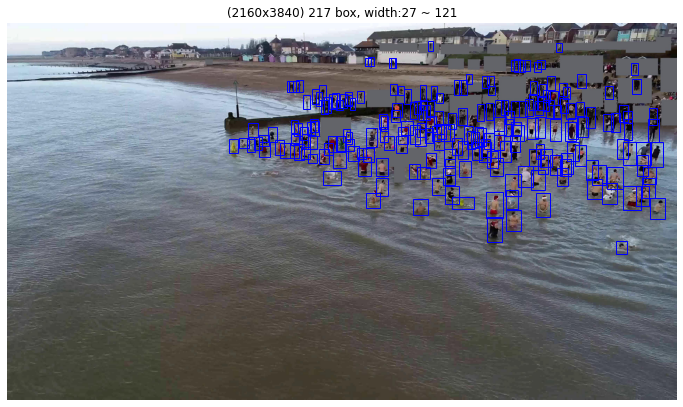

In [99]:
for example in tfds.as_numpy(dataset):
    #print(example[0].shape, example[1].shape)
    
    image = tf.cast(example[0], dtype=tf.float32)
    cls_bbox = example[1]        
    print('cls_bbox', cls_bbox)
    
    label = tf.cast(cls_bbox[:, 0],dtype=tf.int32)
    bbox = cls_bbox[:, 1:]
    h, w, c = image.shape    
    bbox_ori = bbox * np.array((h,w,h,w)).reshape((1, 4))
    #print('bbox_ori', bbox_ori)
    
    visualize_detections_simple(image,bbox_ori,label)
    break

In [100]:
loss_list = []
recall_list = []
#load_weight()
print(len(input_list_train))

1


In [115]:
epochs = 1000
hist = model.fit(
    train_dataset.take(2),
    validation_data=None,
    epochs=epochs,
    callbacks=None,#callbacks_list
    verbose=1,
)
#143s 399ms/step - loss: 2.3213 - recall: 0.6575 - precision: 2.0488e-04

Epoch 1/1000
1/1 [==============================] - 0s 112ms/step - loss: 2.0460 - recall: 1.0000 - precision: 0.0092
Epoch 2/1000
1/1 [==============================] - 0s 78ms/step - loss: 1.9896 - recall: 1.0000 - precision: 0.0086
Epoch 3/1000
1/1 [==============================] - 0s 116ms/step - loss: 2.0453 - recall: 1.0000 - precision: 0.0091
Epoch 4/1000
1/1 [==============================] - 0s 86ms/step - loss: 1.9730 - recall: 1.0000 - precision: 0.0089
Epoch 5/1000
1/1 [==============================] - 0s 71ms/step - loss: 2.1257 - recall: 1.0000 - precision: 0.0077
Epoch 6/1000
1/1 [==============================] - 0s 81ms/step - loss: 1.9592 - recall: 1.0000 - precision: 0.0087
Epoch 7/1000
1/1 [==============================] - 0s 96ms/step - loss: 2.1739 - recall: 1.0000 - precision: 0.0089
Epoch 8/1000
1/1 [==============================] - 0s 95ms/step - loss: 2.0579 - recall: 1.0000 - precision: 0.0087
Epoch 9/1000
1/1 [==============================] - 0s 86ms/st

1/1 [==============================] - 0s 92ms/step - loss: 1.8232 - recall: 1.0000 - precision: 0.0072
Epoch 71/1000
1/1 [==============================] - 0s 75ms/step - loss: 2.0645 - recall: 1.0000 - precision: 0.0090
Epoch 72/1000
1/1 [==============================] - 0s 76ms/step - loss: 1.8157 - recall: 1.0000 - precision: 0.0078
Epoch 73/1000
1/1 [==============================] - 0s 95ms/step - loss: 1.9409 - recall: 1.0000 - precision: 0.0089
Epoch 74/1000
1/1 [==============================] - 0s 86ms/step - loss: 1.9701 - recall: 1.0000 - precision: 0.0085
Epoch 75/1000
1/1 [==============================] - 0s 82ms/step - loss: 2.0784 - recall: 1.0000 - precision: 0.0086
Epoch 76/1000
1/1 [==============================] - 0s 96ms/step - loss: 1.9223 - recall: 1.0000 - precision: 0.0086
Epoch 77/1000
1/1 [==============================] - 0s 95ms/step - loss: 1.9457 - recall: 1.0000 - precision: 0.0091
Epoch 78/1000
1/1 [==============================] - 0s 86ms/step - lo

1/1 [==============================] - 0s 86ms/step - loss: 1.7150 - recall: 1.0000 - precision: 0.0085
Epoch 140/1000
1/1 [==============================] - 0s 96ms/step - loss: 1.7786 - recall: 1.0000 - precision: 0.0093
Epoch 141/1000
1/1 [==============================] - 0s 96ms/step - loss: 1.7729 - recall: 1.0000 - precision: 0.0092
Epoch 142/1000
1/1 [==============================] - 0s 72ms/step - loss: 2.0547 - recall: 1.0000 - precision: 0.0074
Epoch 143/1000
1/1 [==============================] - 0s 86ms/step - loss: 1.6836 - recall: 1.0000 - precision: 0.0088
Epoch 144/1000
1/1 [==============================] - 0s 82ms/step - loss: 1.6952 - recall: 1.0000 - precision: 0.0086
Epoch 145/1000
1/1 [==============================] - 0s 72ms/step - loss: 1.7398 - recall: 1.0000 - precision: 0.0068
Epoch 146/1000
1/1 [==============================] - 0s 71ms/step - loss: 1.6805 - recall: 1.0000 - precision: 0.0069
Epoch 147/1000
1/1 [==============================] - 0s 83ms/s

Epoch 208/1000
1/1 [==============================] - 0s 95ms/step - loss: 1.8765 - recall: 1.0000 - precision: 0.0093
Epoch 209/1000
1/1 [==============================] - 0s 96ms/step - loss: 1.7115 - recall: 1.0000 - precision: 0.0092
Epoch 210/1000
1/1 [==============================] - 0s 76ms/step - loss: 1.7561 - recall: 1.0000 - precision: 0.0078
Epoch 211/1000
1/1 [==============================] - 0s 75ms/step - loss: 1.7843 - recall: 1.0000 - precision: 0.0078
Epoch 212/1000
1/1 [==============================] - 0s 86ms/step - loss: 1.6078 - recall: 1.0000 - precision: 0.0080
Epoch 213/1000
1/1 [==============================] - 0s 76ms/step - loss: 1.6082 - recall: 1.0000 - precision: 0.0088
Epoch 214/1000
1/1 [==============================] - 0s 86ms/step - loss: 1.6874 - recall: 1.0000 - precision: 0.0085
Epoch 215/1000
1/1 [==============================] - 0s 88ms/step - loss: 1.6063 - recall: 1.0000 - precision: 0.0083
Epoch 216/1000
1/1 [============================

1/1 [==============================] - 0s 71ms/step - loss: 1.6018 - recall: 1.0000 - precision: 0.0069
Epoch 277/1000
1/1 [==============================] - 0s 86ms/step - loss: 1.6197 - recall: 1.0000 - precision: 0.0079
Epoch 278/1000
1/1 [==============================] - 0s 82ms/step - loss: 1.5733 - recall: 1.0000 - precision: 0.0084
Epoch 279/1000
1/1 [==============================] - 0s 72ms/step - loss: 1.5048 - recall: 1.0000 - precision: 0.0072
Epoch 280/1000
1/1 [==============================] - 0s 99ms/step - loss: 1.8211 - recall: 1.0000 - precision: 0.0094
Epoch 281/1000
1/1 [==============================] - 0s 76ms/step - loss: 1.5748 - recall: 1.0000 - precision: 0.0085
Epoch 282/1000
1/1 [==============================] - 0s 85ms/step - loss: 1.6150 - recall: 1.0000 - precision: 0.0077
Epoch 283/1000
1/1 [==============================] - 0s 89ms/step - loss: 1.5359 - recall: 1.0000 - precision: 0.0083
Epoch 284/1000
1/1 [==============================] - 0s 96ms/s

Epoch 345/1000
1/1 [==============================] - 0s 96ms/step - loss: 1.5774 - recall: 1.0000 - precision: 0.0088
Epoch 346/1000
1/1 [==============================] - 0s 96ms/step - loss: 1.6327 - recall: 1.0000 - precision: 0.0089
Epoch 347/1000
1/1 [==============================] - 0s 76ms/step - loss: 1.7303 - recall: 1.0000 - precision: 0.0080
Epoch 348/1000
1/1 [==============================] - 0s 116ms/step - loss: 1.5032 - recall: 1.0000 - precision: 0.0086
Epoch 349/1000
1/1 [==============================] - 0s 76ms/step - loss: 1.5728 - recall: 1.0000 - precision: 0.0074
Epoch 350/1000
1/1 [==============================] - 0s 86ms/step - loss: 1.5565 - recall: 1.0000 - precision: 0.0082
Epoch 351/1000
1/1 [==============================] - 0s 96ms/step - loss: 1.7420 - recall: 1.0000 - precision: 0.0088
Epoch 352/1000
1/1 [==============================] - 0s 96ms/step - loss: 1.7340 - recall: 1.0000 - precision: 0.0094
Epoch 353/1000
1/1 [===========================

1/1 [==============================] - 0s 87ms/step - loss: 1.4698 - recall: 1.0000 - precision: 0.0079
Epoch 414/1000
1/1 [==============================] - 0s 72ms/step - loss: 1.4431 - recall: 1.0000 - precision: 0.0069
Epoch 415/1000
1/1 [==============================] - 0s 76ms/step - loss: 1.3941 - recall: 1.0000 - precision: 0.0078
Epoch 416/1000
1/1 [==============================] - 0s 96ms/step - loss: 1.7065 - recall: 1.0000 - precision: 0.0091
Epoch 417/1000
1/1 [==============================] - 0s 87ms/step - loss: 1.5264 - recall: 1.0000 - precision: 0.0087
Epoch 418/1000
1/1 [==============================] - 0s 72ms/step - loss: 1.5621 - recall: 1.0000 - precision: 0.0071
Epoch 419/1000
1/1 [==============================] - 0s 96ms/step - loss: 1.6280 - recall: 1.0000 - precision: 0.0092
Epoch 420/1000
1/1 [==============================] - 0s 76ms/step - loss: 1.4245 - recall: 1.0000 - precision: 0.0089
Epoch 421/1000
1/1 [==============================] - 0s 84ms/s

Epoch 482/1000
1/1 [==============================] - 0s 76ms/step - loss: 1.3268 - recall: 1.0000 - precision: 0.0080
Epoch 483/1000
1/1 [==============================] - 0s 95ms/step - loss: 1.5872 - recall: 1.0000 - precision: 0.0093
Epoch 484/1000
1/1 [==============================] - 0s 96ms/step - loss: 1.4417 - recall: 1.0000 - precision: 0.0086
Epoch 485/1000
1/1 [==============================] - 0s 86ms/step - loss: 1.4120 - recall: 1.0000 - precision: 0.0090
Epoch 486/1000
1/1 [==============================] - 0s 95ms/step - loss: 1.4417 - recall: 1.0000 - precision: 0.0085
Epoch 487/1000
1/1 [==============================] - 0s 76ms/step - loss: 1.5071 - recall: 1.0000 - precision: 0.0081
Epoch 488/1000
1/1 [==============================] - 0s 76ms/step - loss: 1.3568 - recall: 1.0000 - precision: 0.0079
Epoch 489/1000
1/1 [==============================] - 0s 95ms/step - loss: 1.6135 - recall: 1.0000 - precision: 0.0090
Epoch 490/1000
1/1 [============================

1/1 [==============================] - 0s 95ms/step - loss: 1.4342 - recall: 1.0000 - precision: 0.0093
Epoch 551/1000
1/1 [==============================] - 0s 72ms/step - loss: 1.6018 - recall: 1.0000 - precision: 0.0070
Epoch 552/1000
1/1 [==============================] - 0s 76ms/step - loss: 1.3530 - recall: 1.0000 - precision: 0.0089
Epoch 553/1000
1/1 [==============================] - 0s 86ms/step - loss: 1.3662 - recall: 1.0000 - precision: 0.0081
Epoch 554/1000
1/1 [==============================] - 0s 86ms/step - loss: 1.3583 - recall: 1.0000 - precision: 0.0080
Epoch 555/1000
1/1 [==============================] - 0s 87ms/step - loss: 1.3530 - recall: 1.0000 - precision: 0.0080
Epoch 556/1000
1/1 [==============================] - 0s 76ms/step - loss: 1.3183 - recall: 1.0000 - precision: 0.0081
Epoch 557/1000
1/1 [==============================] - 0s 96ms/step - loss: 1.5157 - recall: 1.0000 - precision: 0.0092
Epoch 558/1000
1/1 [==============================] - 0s 95ms/s

Epoch 619/1000
1/1 [==============================] - 0s 72ms/step - loss: 1.5620 - recall: 1.0000 - precision: 0.0073
Epoch 620/1000
1/1 [==============================] - 0s 97ms/step - loss: 1.4159 - recall: 1.0000 - precision: 0.0093
Epoch 621/1000
1/1 [==============================] - 0s 96ms/step - loss: 1.4251 - recall: 1.0000 - precision: 0.0089
Epoch 622/1000
1/1 [==============================] - 0s 76ms/step - loss: 1.3290 - recall: 1.0000 - precision: 0.0077
Epoch 623/1000
1/1 [==============================] - 0s 72ms/step - loss: 1.3696 - recall: 1.0000 - precision: 0.0075
Epoch 624/1000
1/1 [==============================] - 0s 96ms/step - loss: 1.4738 - recall: 1.0000 - precision: 0.0091
Epoch 625/1000
1/1 [==============================] - 0s 96ms/step - loss: 1.4710 - recall: 1.0000 - precision: 0.0093
Epoch 626/1000
1/1 [==============================] - 0s 76ms/step - loss: 1.3094 - recall: 1.0000 - precision: 0.0084
Epoch 627/1000
1/1 [============================

1/1 [==============================] - 0s 86ms/step - loss: 1.4294 - recall: 1.0000 - precision: 0.0089
Epoch 688/1000
1/1 [==============================] - 0s 87ms/step - loss: 1.3138 - recall: 1.0000 - precision: 0.0083
Epoch 689/1000
1/1 [==============================] - 0s 76ms/step - loss: 1.3004 - recall: 1.0000 - precision: 0.0082
Epoch 690/1000
1/1 [==============================] - 0s 86ms/step - loss: 1.3645 - recall: 1.0000 - precision: 0.0089
Epoch 691/1000
1/1 [==============================] - 0s 76ms/step - loss: 1.2377 - recall: 1.0000 - precision: 0.0081
Epoch 692/1000
1/1 [==============================] - 0s 96ms/step - loss: 1.3400 - recall: 1.0000 - precision: 0.0086
Epoch 693/1000
1/1 [==============================] - 0s 71ms/step - loss: 1.3540 - recall: 1.0000 - precision: 0.0071
Epoch 694/1000
1/1 [==============================] - 0s 86ms/step - loss: 1.2989 - recall: 1.0000 - precision: 0.0080
Epoch 695/1000
1/1 [==============================] - 0s 76ms/s

Epoch 756/1000
1/1 [==============================] - 0s 86ms/step - loss: 1.3347 - recall: 1.0000 - precision: 0.0082
Epoch 757/1000
1/1 [==============================] - 0s 96ms/step - loss: 1.4404 - recall: 1.0000 - precision: 0.0089
Epoch 758/1000
1/1 [==============================] - 0s 71ms/step - loss: 1.7488 - recall: 1.0000 - precision: 0.0068
Epoch 759/1000
1/1 [==============================] - 0s 76ms/step - loss: 1.3588 - recall: 1.0000 - precision: 0.0086
Epoch 760/1000
1/1 [==============================] - 0s 86ms/step - loss: 1.2981 - recall: 1.0000 - precision: 0.0086
Epoch 761/1000
1/1 [==============================] - 0s 95ms/step - loss: 1.4309 - recall: 1.0000 - precision: 0.0087
Epoch 762/1000
1/1 [==============================] - 0s 71ms/step - loss: 1.3291 - recall: 1.0000 - precision: 0.0077
Epoch 763/1000
1/1 [==============================] - 0s 76ms/step - loss: 1.2296 - recall: 1.0000 - precision: 0.0077
Epoch 764/1000
1/1 [============================

1/1 [==============================] - 0s 87ms/step - loss: 1.2623 - recall: 1.0000 - precision: 0.0081
Epoch 825/1000
1/1 [==============================] - 0s 96ms/step - loss: 1.3348 - recall: 1.0000 - precision: 0.0091
Epoch 826/1000
1/1 [==============================] - 0s 86ms/step - loss: 1.2983 - recall: 1.0000 - precision: 0.0084
Epoch 827/1000
1/1 [==============================] - 0s 86ms/step - loss: 1.3107 - recall: 1.0000 - precision: 0.0084
Epoch 828/1000
1/1 [==============================] - 0s 96ms/step - loss: 1.3115 - recall: 1.0000 - precision: 0.0093
Epoch 829/1000
1/1 [==============================] - 0s 71ms/step - loss: 1.4274 - recall: 1.0000 - precision: 0.0067
Epoch 830/1000
1/1 [==============================] - 0s 96ms/step - loss: 1.3080 - recall: 1.0000 - precision: 0.0088
Epoch 831/1000
1/1 [==============================] - 0s 86ms/step - loss: 1.2873 - recall: 1.0000 - precision: 0.0086
Epoch 832/1000
1/1 [==============================] - 0s 86ms/s

Epoch 893/1000
1/1 [==============================] - 0s 86ms/step - loss: 1.2876 - recall: 1.0000 - precision: 0.0085
Epoch 894/1000
1/1 [==============================] - 0s 86ms/step - loss: 1.2808 - recall: 1.0000 - precision: 0.0086
Epoch 895/1000
1/1 [==============================] - 0s 82ms/step - loss: 1.1734 - recall: 1.0000 - precision: 0.0087
Epoch 896/1000
1/1 [==============================] - 0s 100ms/step - loss: 1.2463 - recall: 1.0000 - precision: 0.0085
Epoch 897/1000
1/1 [==============================] - 0s 72ms/step - loss: 1.2551 - recall: 1.0000 - precision: 0.0072
Epoch 898/1000
1/1 [==============================] - 0s 95ms/step - loss: 1.2881 - recall: 1.0000 - precision: 0.0090
Epoch 899/1000
1/1 [==============================] - 0s 76ms/step - loss: 1.1213 - recall: 1.0000 - precision: 0.0087
Epoch 900/1000
1/1 [==============================] - 0s 76ms/step - loss: 1.2043 - recall: 1.0000 - precision: 0.0074
Epoch 901/1000
1/1 [===========================

1/1 [==============================] - 0s 72ms/step - loss: 1.1602 - recall: 1.0000 - precision: 0.0077
Epoch 962/1000
1/1 [==============================] - 0s 72ms/step - loss: 1.1120 - recall: 1.0000 - precision: 0.0074
Epoch 963/1000
1/1 [==============================] - 0s 76ms/step - loss: 1.0292 - recall: 1.0000 - precision: 0.0078
Epoch 964/1000
1/1 [==============================] - 0s 95ms/step - loss: 1.4351 - recall: 1.0000 - precision: 0.0090
Epoch 965/1000
1/1 [==============================] - 0s 76ms/step - loss: 1.0728 - recall: 1.0000 - precision: 0.0075
Epoch 966/1000
1/1 [==============================] - 0s 72ms/step - loss: 1.0837 - recall: 1.0000 - precision: 0.0074
Epoch 967/1000
1/1 [==============================] - 0s 76ms/step - loss: 1.0477 - recall: 1.0000 - precision: 0.0080
Epoch 968/1000
1/1 [==============================] - 0s 86ms/step - loss: 1.1717 - recall: 1.0000 - precision: 0.0083
Epoch 969/1000
1/1 [==============================] - 0s 76ms/s

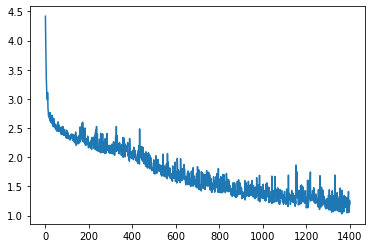

In [116]:
loss_list.extend(hist.history['loss'])
recall_list.extend(hist.history['recall'])

plt.plot(np.array(loss_list).reshape([-1]))
#plt.plot(np.array(recall_list).reshape([-1]))

num_detections 100


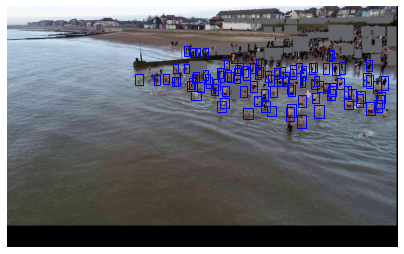

In [120]:
is_load = False
if is_load:
    weights_dir = model_dir#"data"
    latest_checkpoint = tf.train.latest_checkpoint(weights_dir)
    print('latest_checkpoint', latest_checkpoint)
    model.load_weights(latest_checkpoint)

image = tf.keras.Input(shape=[None, None, 3], name="image")
predictions = model(image, training=False)
detections = DecodePredictions(confidence_threshold=0.5)(image, predictions)
inference_model = tf.keras.Model(inputs=image, outputs=detections)

def prepare_image(image):
    image, _, ratio = resize_and_pad_image(image, jitter=None)
    return tf.expand_dims(image, axis=0), ratio

int2str = WATER_CLASSES
for image, cbbox in val_dataset.take(1):        
    image = image[0]      
    input_image, ratio = prepare_image(image)
    detections = inference_model.predict(input_image)        
    num_detections = detections.valid_detections[0]
    #print(detections)
    print('num_detections', num_detections)
 
    class_names = [WATER_CLASSES[(int(x))] for x in detections.nmsed_classes[0][:num_detections]    ]
    visualize_detections(
        image,
        detections.nmsed_boxes[0][:num_detections] / ratio,
        class_names,
        detections.nmsed_scores[0][:num_detections],
    )